## AutoGluon Model

In this notebook, we train an AutoGluon model (without any feature engineering) which ties for 4th place out of 4,318 teams.  Arguably, this is the simplest high scoring model in the Kaggle competition.  After the model is trained, a residual plot is created and we address the explainability of the model.  Since the dataset for this Kaggle competition was synthetically generated from an existing dataset, we use our model on the original dataset to predict calorie expenditure.  Spoiler alert: it does very well.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from autogluon.tabular import TabularPredictor
import shap
from shap import KernelExplainer

In [2]:
# load train/test files
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
# log transform Calories and set Sex column as categorical
train_log = train
train_log['Calories'] = np.log1p(train['Calories'])
train_log['Sex'] = train_log['Sex'].astype('category')

# Encode Sex categorical feature to be compatable with SHAP
encoder = OrdinalEncoder()

train_log_enc = train_log.copy()
train_log_enc['Sex'] = encoder.fit_transform(train_log[['Sex']]).astype(int)

testsub = test.copy()
testsub['Sex'] = encoder.fit_transform(testsub[['Sex']]).astype(int)

train_log_enc.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


In [4]:
# Split data into training and testing sets
train_data, test_data = train_test_split(train_log_enc, test_size=0.2, random_state=724)

No path specified. Models will be saved in: "AutogluonModels\ag-20250624_192943"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       22.46 GB / 31.61 GB (71.0%)
Disk Space Avail:   174.39 GB / 455.74 GB (38.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then hold

(_ray_fit pid=22248) [1000]	valid_set's rmse: 0.0641906
(_ray_fit pid=16180) [2000]	valid_set's rmse: 0.0599325 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=16180) [3000]	valid_set's rmse: 0.0595838 [repeated 5x across cluster]
(_ray_fit pid=16180) [4000]	valid_set's rmse: 0.0594207 [repeated 5x across cluster]
(_ray_fit pid=16180) [5000]	valid_set's rmse: 0.0593537 [repeated 5x across cluster]
(_ray_fit pid=16180) [6000]	valid_set's rmse: 0.0593362 [repeated 5x across cluster]
(_ray_fit pid=16180) [7000]	valid_set's rmse: 0.0593263 [repeated 4x across cluster]
(_ray_fit pid=16180) [8000]	valid_set's rmse: 0.0593195 [repeated 3x across cluster]
(_ray_fit pid=16180) [9000]	valid_set's rmse: 0.0593148
(_ray_fit pid=16180) [10000]	valid_set's rmse: 0.0593298


(_dystack pid=21016) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	196.96s	 = Training   runtime
(_dystack pid=21016) 	272.53s	 = Validation runtime
(_dystack pid=21016) Fitting model: LightGBM_BAG_L1 ... Training model for up to 9331.71s of the 14132.36s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=0.88%)


(_ray_fit pid=7816) [1000]	valid_set's rmse: 0.062869
(_ray_fit pid=10260) [1000]	valid_set's rmse: 0.0596077
(_ray_fit pid=10260) [2000]	valid_set's rmse: 0.0594929 [repeated 4x across cluster]


(_dystack pid=21016) 	-0.0606	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	30.54s	 = Training   runtime
(_dystack pid=21016) 	17.85s	 = Validation runtime
(_dystack pid=21016) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 9294.69s of the 14095.34s of remaining time.
(_dystack pid=21016) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=21016)   warnings.warn(
(_dystack pid=21016) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	58.83s	 = Training   runtime
(_dystack pid=21016) 	14.36s	 = Validation runtime
(_dystack pid=21016) Fitting model: CatBoost_BAG_L1 ... Training model for up to 9220.95s of the 14021.59s of remaining time.
(_dystac

(_ray_fit pid=14260) [1000]	valid_set's rmse: 0.0603741


(_dystack pid=21016) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	20.33s	 = Training   runtime
(_dystack pid=21016) 	13.15s	 = Validation runtime
(_dystack pid=21016) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 8365.30s of the 13165.95s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=2.62%)
(_dystack pid=21016) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	111.03s	 = Training   runtime
(_dystack pid=21016) 	0.12s	 = Validation runtime
(_dystack pid=21016) Fitting model: NeuralNetTorch_r79_BAG_L1 ... Training model for up to 8251.10s of the 13051.75s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=0.83%)
(_dystack pid=21016) 	-0.0647	 = Validation score   (-root_mean_s

(_ray_fit pid=17624) [1000]	valid_set's rmse: 0.0611241
(_ray_fit pid=17624) [2000]	valid_set's rmse: 0.0606324 [repeated 5x across cluster]
(_ray_fit pid=17624) [3000]	valid_set's rmse: 0.0605689 [repeated 5x across cluster]
(_ray_fit pid=17624) [4000]	valid_set's rmse: 0.0606035 [repeated 5x across cluster]
(_ray_fit pid=22164) [5000]	valid_set's rmse: 0.0591161 [repeated 5x across cluster]


(_dystack pid=21016) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	100.17s	 = Training   runtime
(_dystack pid=21016) 	210.82s	 = Validation runtime
(_dystack pid=21016) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 7001.59s of the 11802.24s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=1.49%)
(_ray_fit pid=10960) No improvement since epoch 0: early stopping
(_ray_fit pid=17644) No improvement since epoch 4: early stopping
(_ray_fit pid=17028) No improvement since epoch 4: early stopping
(_dystack pid=21016) 	-0.0681	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	1389.03s	 = Training   runtime
(_dystack pid=21016) 	9.3s	 = Validation runtime
(_dystack pid=21016) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 5608.04s of the 10408.68s of remaining time.
(_dystack pid=210

(_ray_fit pid=3560) [1000]	valid_set's rmse: 0.0878982 [repeated 2x across cluster]
(_ray_fit pid=3560) [2000]	valid_set's rmse: 0.0772614 [repeated 5x across cluster]
(_ray_fit pid=11056) [2000]	valid_set's rmse: 0.0765656 [repeated 2x across cluster]
(_ray_fit pid=13448) [3000]	valid_set's rmse: 0.0692236 [repeated 3x across cluster]
(_ray_fit pid=11056) [3000]	valid_set's rmse: 0.0703525 [repeated 2x across cluster]
(_ray_fit pid=13448) [4000]	valid_set's rmse: 0.0662483 [repeated 3x across cluster]
(_ray_fit pid=11056) [4000]	valid_set's rmse: 0.0663643 [repeated 2x across cluster]
(_ray_fit pid=3560) [5000]	valid_set's rmse: 0.0648822 [repeated 4x across cluster]
(_ray_fit pid=20116) [5000]	valid_set's rmse: 0.0633014
(_ray_fit pid=11056) [5000]	valid_set's rmse: 0.063777
(_ray_fit pid=13448) [7000]	valid_set's rmse: 0.0627078 [repeated 4x across cluster]
(_ray_fit pid=13448) [8000]	valid_set's rmse: 0.0621875 [repeated 5x across cluster]
(_ray_fit pid=11056) [7000]	valid_set's rm

(_dystack pid=21016) 	-0.0611	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	203.16s	 = Training   runtime
(_dystack pid=21016) 	496.4s	 = Validation runtime
(_dystack pid=21016) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 5105.83s of the 9906.48s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=0.85%)
(_dystack pid=21016) 	-0.063	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	489.39s	 = Training   runtime
(_dystack pid=21016) 	2.13s	 = Validation runtime
(_dystack pid=21016) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 4612.98s of the 9413.62s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=1.26%)
(_dystack pid=21016) 	-0.0605	 = Validation score   (-root_mean_squ

(_ray_fit pid=10916) [1000]	valid_set's rmse: 0.0643265 [repeated 3x across cluster]
(_ray_fit pid=19272) [2000]	valid_set's rmse: 0.0616884 [repeated 5x across cluster]
(_ray_fit pid=9376) [2000]	valid_set's rmse: 0.0629073 [repeated 4x across cluster]
(_ray_fit pid=19272) [3000]	valid_set's rmse: 0.061053
(_ray_fit pid=10916) [3000]	valid_set's rmse: 0.0596468
(_ray_fit pid=9376) [3000]	valid_set's rmse: 0.0623998 [repeated 3x across cluster]
(_ray_fit pid=19272) [4000]	valid_set's rmse: 0.0608458
(_ray_fit pid=10916) [4000]	valid_set's rmse: 0.0594821
(_ray_fit pid=9376) [4000]	valid_set's rmse: 0.062283 [repeated 3x across cluster]
(_ray_fit pid=10916) [5000]	valid_set's rmse: 0.0593999
(_ray_fit pid=19272) [5000]	valid_set's rmse: 0.0607533
(_ray_fit pid=9376) [5000]	valid_set's rmse: 0.0622918 [repeated 3x across cluster]
(_ray_fit pid=10916) [6000]	valid_set's rmse: 0.0593729
(_ray_fit pid=19272) [6000]	valid_set's rmse: 0.0607352
(_ray_fit pid=10916) [7000]	valid_set's rmse: 0.

(_dystack pid=21016) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	270.65s	 = Training   runtime
(_dystack pid=21016) 	470.69s	 = Validation runtime
(_dystack pid=21016) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 3104.12s of the 7904.76s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=1.51%)
(_ray_fit pid=12932) No improvement since epoch 2: early stopping
(_ray_fit pid=9804) No improvement since epoch 3: early stopping
(_dystack pid=21016) 	-0.0674	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	1271.94s	 = Training   runtime
(_dystack pid=21016) 	10.69s	 = Validation runtime
(_dystack pid=21016) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 1826.93s of the 6627.57s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLo

(_ray_fit pid=19076) [1000]	valid_set's rmse: 0.0627098 [repeated 2x across cluster]


(_dystack pid=21016) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	24.61s	 = Training   runtime
(_dystack pid=21016) 	18.17s	 = Validation runtime
(_dystack pid=21016) Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 721.64s of the 5522.28s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=0.84%)
(_ray_fit pid=2300) 	Ran out of time, stopping training early. (Stopping on epoch 19)
(_ray_fit pid=12588) 	Ran out of time, stopping training early. (Stopping on epoch 19)
(_ray_fit pid=22144) 	Ran out of time, stopping training early. (Stopping on epoch 19)
(_ray_fit pid=13272) 	Ran out of time, stopping training early. (Stopping on epoch 20) [repeated 2x across cluster]
(_dystack pid=21016) 	-0.094	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	571.47s	 = Training   runtime
(_dystack pid=21016) 	4.3

(_ray_fit pid=16484) [1000]	valid_set's rmse: 0.0606641 [repeated 2x across cluster]
(_ray_fit pid=21948) [2000]	valid_set's rmse: 0.0607638 [repeated 5x across cluster]
(_ray_fit pid=2924) [3000]	valid_set's rmse: 0.0594518 [repeated 3x across cluster]
(_ray_fit pid=2924) [4000]	valid_set's rmse: 0.0594641 [repeated 2x across cluster]


(_dystack pid=21016) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	116.74s	 = Training   runtime
(_dystack pid=21016) 	34.42s	 = Validation runtime
(_dystack pid=21016) Fitting model: LightGBM_BAG_L2 ... Training model for up to 4616.24s of the 4616.02s of remaining time.
(_dystack pid=21016) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=2.81%)
(_dystack pid=21016) 	-0.0597	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	14.86s	 = Training   runtime
(_dystack pid=21016) 	1.65s	 = Validation runtime
(_dystack pid=21016) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4597.20s of the 4596.98s of remaining time.
(_dystack pid=21016) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validat

(_ray_fit pid=16180) [1000]	valid_set's rmse: 0.061246
(_ray_fit pid=11180) [1000]	valid_set's rmse: 0.0606815
(_ray_fit pid=11180) [2000]	valid_set's rmse: 0.060367 [repeated 4x across cluster]
(_ray_fit pid=11180) [3000]	valid_set's rmse: 0.0602749 [repeated 5x across cluster]


(_ray_fit pid=11180) 	Ran out of time, early stopping on iteration 3158. Best iteration is:
(_ray_fit pid=11180) 	[3158]	valid_set's rmse: 0.0602689
(_dystack pid=21016) 	-0.0599	 = Validation score   (-root_mean_squared_error)
(_dystack pid=21016) 	83.13s	 = Training   runtime
(_dystack pid=21016) 	146.97s	 = Validation runtime
(_ray_fit pid=6772) 	Ran out of time, early stopping on iteration 3104. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=6772) 	[3104]	valid_set's rmse: 0.0596824 [repeated 4x across cluster]
(_dystack pid=21016) Fitting model: WeightedEnsemble_L3 ... Training model for up to 474.50s of the -13.90s of remaining time.
(_dystack pid=21016) 	Ensemble Weights: {'ExtraTreesMSE_BAG_L2': 0.25, 'XGBoost_r33_BAG_L1': 0.1, 'LightGBMXT_BAG_L2': 0.1, 'LightGBM_BAG_L2': 0.1, 'CatBoost_r177_BAG_L2': 0.1, 'LightGBMLarge_BAG_L1': 0.05, 'ExtraTrees_r42_BAG_L1': 0.05, 'NeuralNetFastAI_r102_BAG_L1': 0.05, 'CatBoost_r13_BAG_L1': 0.05, 'CatBoost_r50_BAG_L1': 0.05, 'Ran


Train prediction: 0.053442659350769854
Test prediction: 0.05894515460437608


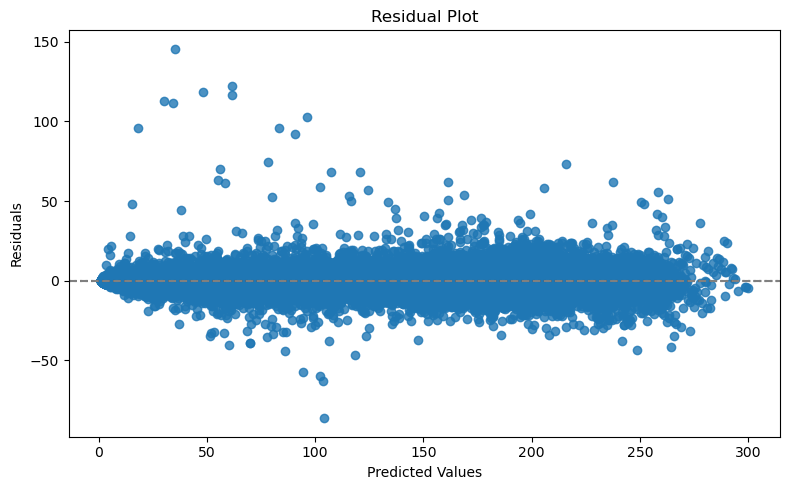

       id    Calories
0  750000   27.237396
1  750001  108.123169
2  750002   87.159729
3  750003  125.750404
4  750004   75.932137

count    250000.000000
mean         88.183640
std          62.283081
min           1.044195
25%          34.042896
50%          76.412315
75%         135.399612
max         299.954407
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05846 private, 0.05708 public (autogluon_prediction_14.csv) (tied for 4th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=57600, # 16 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(testsub)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_13.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### Explainability

What is this AutoGluon model comprised of and what features does it value?

In [7]:
# load model information
# predictor = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250624_192943")
info = predictor.info()

In [8]:
print("AutoGluon trained a total of", len(predictor.leaderboard()), "different models.  " \
"The top performing model is", predictor.leaderboard().iloc[0]['model'], "which is a stacked ensemble of")
info['model_info']['WeightedEnsemble_L3']['features']

AutoGluon trained a total of 91 different models.  The top performing model is WeightedEnsemble_L3 which is a stacked ensemble of


['CatBoost_r9_BAG_L2',
 'XGBoost_BAG_L1',
 'CatBoost_r167_BAG_L1',
 'CatBoost_BAG_L2',
 'ExtraTrees_r42_BAG_L2',
 'RandomForest_r39_BAG_L1',
 'ExtraTreesMSE_BAG_L2',
 'NeuralNetFastAI_r156_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'LightGBMLarge_BAG_L1',
 'XGBoost_r33_BAG_L2',
 'XGBoost_r33_BAG_L1',
 'LightGBM_r188_BAG_L2',
 'XGBoost_r194_BAG_L1',
 'NeuralNetFastAI_BAG_L1',
 'NeuralNetFastAI_r134_BAG_L1']

In [11]:
print("The top 10 performing models are:")
predictor.leaderboard().head(10)

The top 10 performing models are:


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059066,root_mean_squared_error,4900.661014,31731.824962,0.007716,10.089905,3,True,91
1,WeightedEnsemble_L2,-0.059184,root_mean_squared_error,1395.381577,3273.044425,0.011702,8.593699,2,True,68
2,ExtraTrees_r42_BAG_L2,-0.059408,root_mean_squared_error,4683.331783,26592.966182,24.825342,347.157124,2,True,86
3,ExtraTreesMSE_BAG_L2,-0.059433,root_mean_squared_error,4682.005436,26690.949035,23.498996,445.139976,2,True,73
4,CatBoost_r9_BAG_L2,-0.059473,root_mean_squared_error,4659.725349,26604.202456,1.218908,358.393398,2,True,82
5,LightGBMLarge_BAG_L2,-0.059511,root_mean_squared_error,4664.282716,26300.551002,5.776275,54.741943,2,True,77
6,XGBoost_r33_BAG_L2,-0.059513,root_mean_squared_error,4680.755358,26472.512767,22.248917,226.703708,2,True,85
7,LightGBM_r131_BAG_L2,-0.059543,root_mean_squared_error,4675.939694,26358.613658,17.433254,112.804599,2,True,80
8,LightGBM_r96_BAG_L2,-0.059543,root_mean_squared_error,5229.289924,26613.137352,570.783484,367.328294,2,True,83
9,LightGBM_BAG_L2,-0.059554,root_mean_squared_error,4661.078082,26279.762766,2.571642,33.953707,2,True,70


#### Feature importance:

In [12]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	2294.83s	= Expected runtime (458.97s per shuffle set)
	1295.37s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Duration,0.810926,0.011206,4.374313e-09,5,0.833999,0.787853
Heart_Rate,0.464294,0.013498,8.561716e-08,5,0.492086,0.436502
Age,0.113143,0.002219,1.774919e-08,5,0.117713,0.108574
Sex,0.059979,0.002053,1.643913e-07,5,0.064206,0.055753
Body_Temp,0.033334,0.001996,1.535723e-06,5,0.037444,0.029224
Weight,0.017149,0.000566,1.425103e-07,5,0.018315,0.015983
Height,0.003735,0.000332,7.419046e-06,5,0.004419,0.003051


## SHAP values for explainability

Which features contribute most to the models performance?

ExactExplainer explainer: 101it [5:32:14, 199.34s/it]                          
C:\Users\eblac\AppData\Local\Temp\ipykernel_2024\1573759042.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_small)


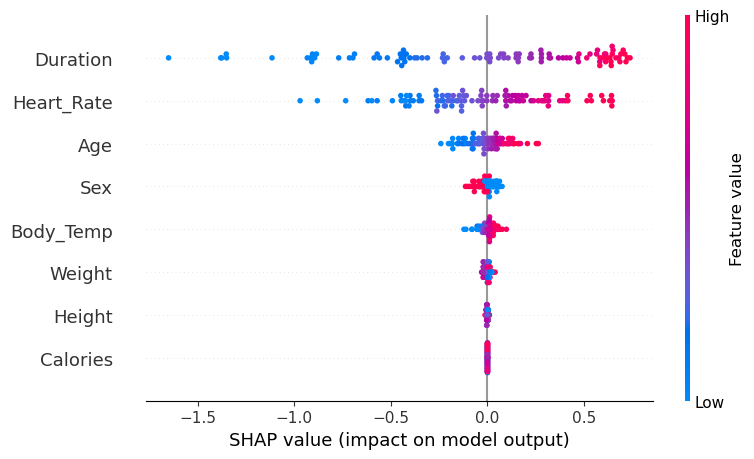

C:\Users\eblac\AppData\Local\Temp\ipykernel_2024\1573759042.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_small, plot_type='bar')


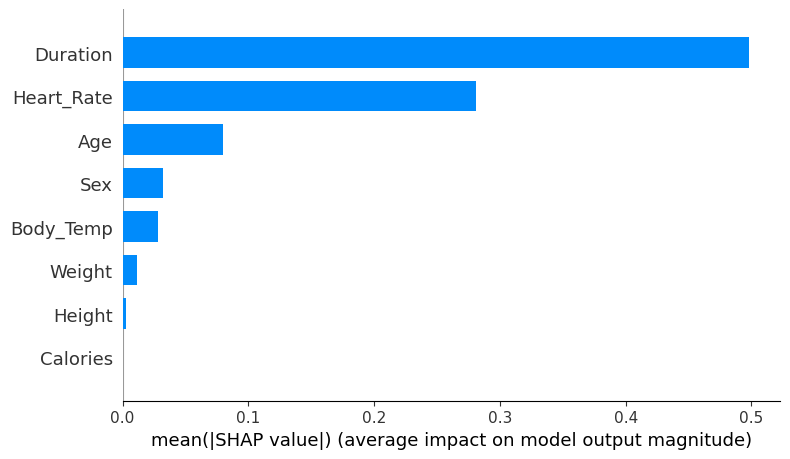

In [15]:
background = shap.sample(train_data, 100, random_state=724)
explainer  = shap.Explainer(predictor.predict, background)

# compute SHAP on 10000-point sample
X_small    = test_data.sample(100, random_state=724)
shap_vals  = explainer(X_small)

# visualize
shap.summary_plot(shap_vals, X_small)
shap.summary_plot(shap_vals, X_small, plot_type='bar')

C:\Users\eblac\AppData\Local\Temp\ipykernel_2024\1059371153.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_small, max_display=7)


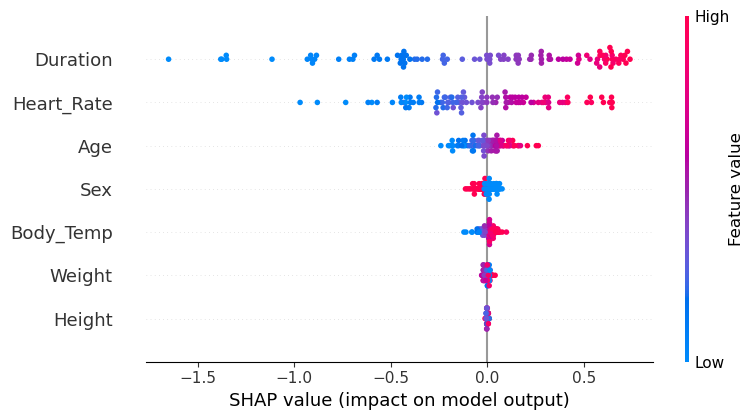

C:\Users\eblac\AppData\Local\Temp\ipykernel_2024\1059371153.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_small, plot_type='bar', max_display=7)


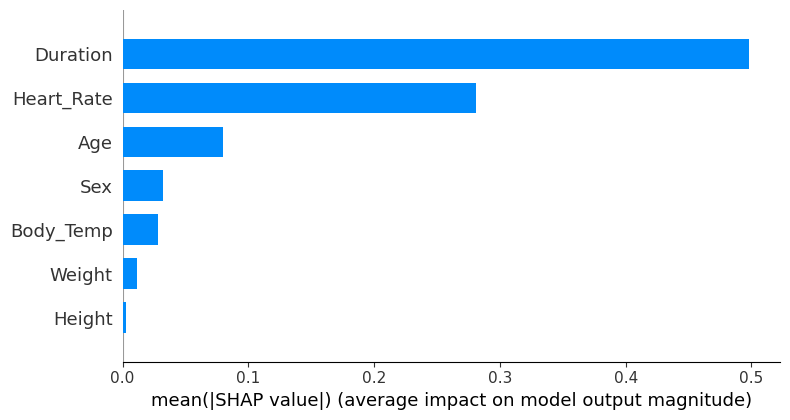

In [34]:
shap.summary_plot(shap_vals, X_small, max_display=7)
shap.summary_plot(shap_vals, X_small, plot_type='bar', max_display=7)

#### SHAP scatter plots

In this plot, we can see that Duration and Heart_Rate appear to be related; as Duration increases, so does Heart_Rate, and the SHAP values.

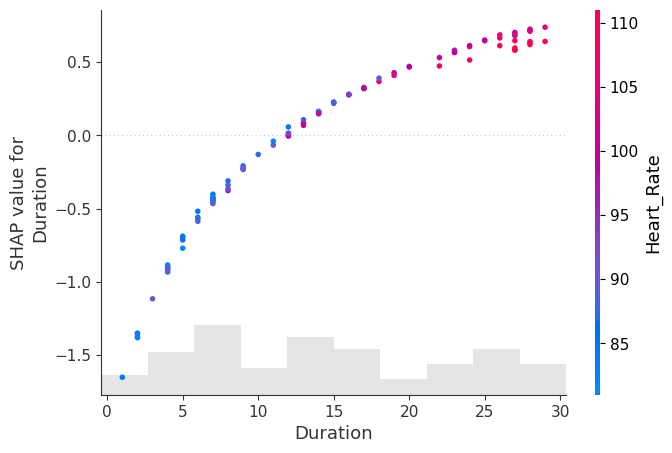

In [36]:
shap.plots.scatter(shap_vals[:,'Duration'], color=shap_vals[:, 'Heart_Rate'])

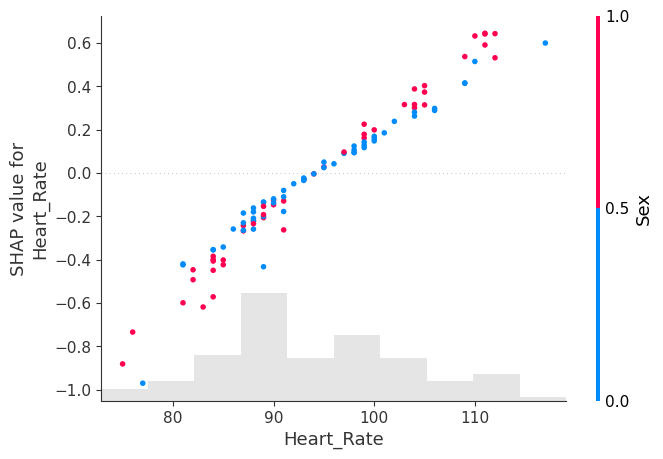

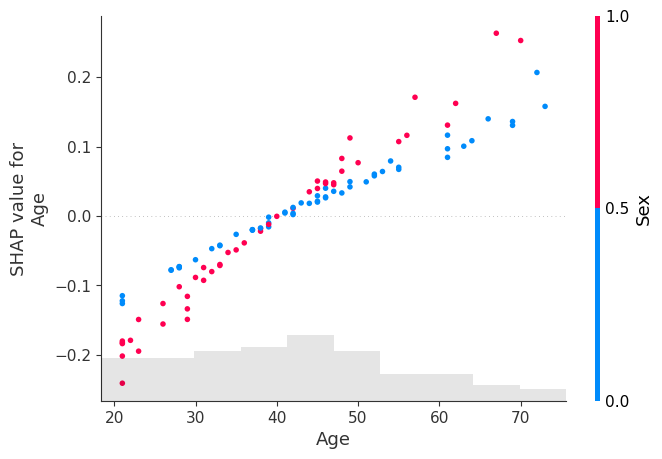

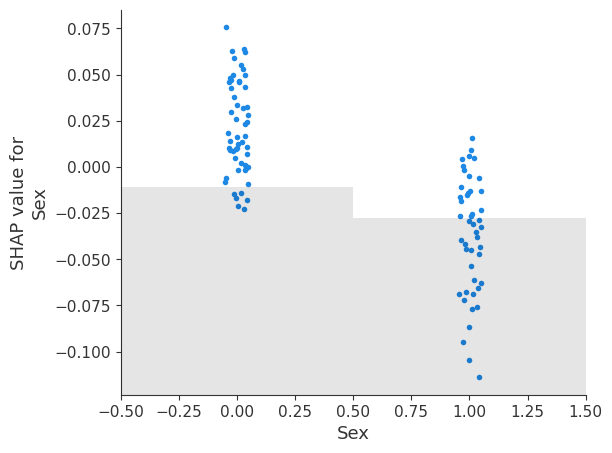

In [38]:
# 0/1 (blue/red) corresponds to female/male

shap.plots.scatter(shap_vals[:,'Heart_Rate'], color=shap_vals[:, 'Sex'])
shap.plots.scatter(shap_vals[:,'Age'], color=shap_vals[:, 'Sex'])
shap.plots.scatter(shap_vals[:,'Sex'])

#### SHAP waterfall plots

Below, $E[f(X)]$ is the mean value of the log-transformed Calories in our sample of the dataset and $f(x)$ is the predicted value of (log-transformed) Calories for the $i^{\mathrm{th}}$ entry of our dataset.  The red/blue arrows with a number inside represent that features impact on the difference between the mean value and predicted value.

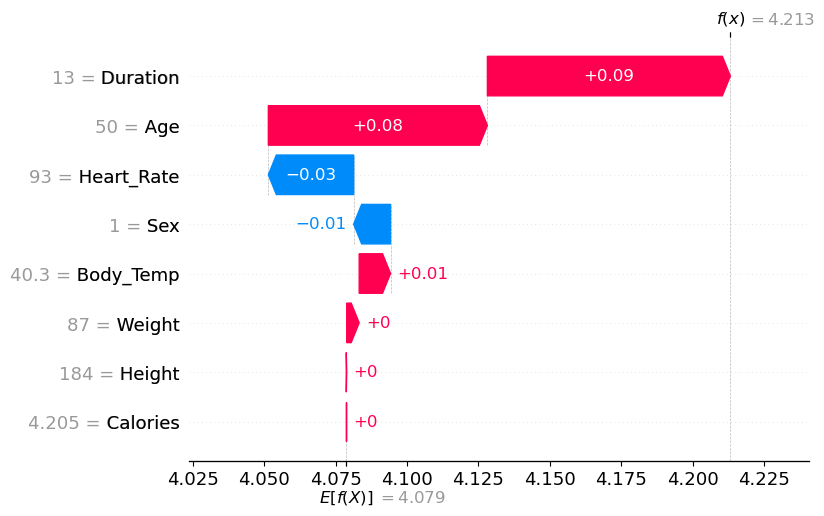

In [52]:
i = 1

shap.plots.waterfall(shap_vals[i])

#### Model performance on original dataset

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Calories Burnt Prediction](https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction) dataset.  How does our model perform on the original dataset?

In [39]:
# read original dataset
orig = pd.read_csv("calories_original_dataset.csv").drop(columns='User_ID')
orig.rename(columns={'Gender': 'Sex'}, inplace=True)
orig['Sex'] = encoder.fit_transform(orig[['Sex']]).astype(int)
orig['Calories'] = np.log1p(orig['Calories'])

orig.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,68,190.0,94.0,29.0,105.0,40.8,5.446737
1,0,20,166.0,60.0,14.0,94.0,40.3,4.204693
2,1,69,179.0,79.0,5.0,88.0,38.7,3.295837
3,0,34,179.0,71.0,13.0,100.0,40.5,4.276666
4,0,27,154.0,58.0,10.0,81.0,39.8,3.583519


Original dataset prediction RMSLE: 0.027458973537079934


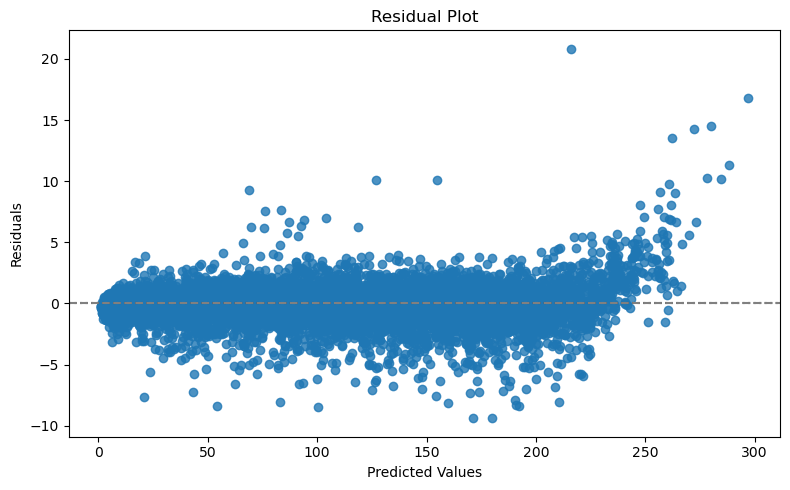

In [40]:
# make prediction
orig_pred = predictor.predict(orig)

print("Original dataset prediction RMSLE:", rmse(orig_pred, orig['Calories']))

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(orig_pred), y=np.expm1(orig['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

The model does an excellent job! (Recall: the Kaggle RMSLE was 0.05846.)

No path specified. Models will be saved in: "AutogluonModels\ag-20250609_212233"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.58 GB / 11.33 GB (49.2%)
Disk Space Avail:   75.36 GB / 237.53 GB (31.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

(_ray_fit pid=8788) [1000]	valid_set's rmse: 0.0625831
(_ray_fit pid=11928) [1000]	valid_set's rmse: 0.0607507 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=8788) [2000]	valid_set's rmse: 0.0610258 [repeated 2x across cluster]
(_ray_fit pid=11928) [2000]	valid_set's rmse: 0.0595853 [repeated 3x across cluster]
(_ray_fit pid=8788) [3000]	valid_set's rmse: 0.0606761 [repeated 2x across cluster]
(_ray_fit pid=11928) [3000]	valid_set's rmse: 0.0593409 [repeated 3x across cluster]
(_ray_fit pid=8788) [4000]	valid_set's rmse: 0.0605654 [repeated 2x across cluster]
(_ray_fit pid=13868) [4000]	valid_set's rmse: 0.0608674 [repeated 2x across cluster]
(_ray_fit pid=11928) [4000]	valid_set's rmse: 0.059248
(_ray_fit pid=16632) [4000]	valid_set's rmse: 0.0624467
(_ray_fit pid=8788) [5000]	va

(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	323.26s	 = Training   runtime
(_dystack pid=4760) 	693.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L1 ... Training model for up to 8499.35s of the 12998.55s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.50%)


(_ray_fit pid=14252) [1000]	valid_set's rmse: 0.0606108
(_ray_fit pid=5388) [2000]	valid_set's rmse: 0.0594929 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0606	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	47.38s	 = Training   runtime
(_dystack pid=4760) 	38.5s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 8438.28s of the 12937.47s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=4760)   warnings.warn(
(_dystack pid=4760) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	101.27s	 = Training   runtime
(_dystack pid=4760) 	16.92s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_BAG_L1 ... Training model for up to 8319.24s of the 12818.43s of remaining time.
(_dystack pid=4760

(_ray_fit pid=15628) [1000]	valid_set's rmse: 0.0603741


(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	36.42s	 = Training   runtime
(_dystack pid=4760) 	28.25s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 7039.38s of the 11538.57s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=10.11%)
(_ray_fit pid=16460) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:69: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=16460)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_s

(_ray_fit pid=9032) [1000]	valid_set's rmse: 0.0596325
(_ray_fit pid=9032) [2000]	valid_set's rmse: 0.0592112 [repeated 5x across cluster]
(_ray_fit pid=9032) [3000]	valid_set's rmse: 0.059135 [repeated 5x across cluster]
(_ray_fit pid=5060) [4000]	valid_set's rmse: 0.0606035 [repeated 5x across cluster]
(_ray_fit pid=7288) [5000]	valid_set's rmse: 0.0591161 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	143.26s	 = Training   runtime
(_dystack pid=4760) 	454.81s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 5124.06s of the 9623.25s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.71%)
(_ray_fit pid=17064) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:131: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=17064)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_ray_fit pid=17064) No improvement since epoch 4: ear

(_ray_fit pid=10936) [1000]	valid_set's rmse: 0.0833397 [repeated 2x across cluster]
(_ray_fit pid=8548) [2000]	valid_set's rmse: 0.0765656 [repeated 5x across cluster]
(_ray_fit pid=10936) [3000]	valid_set's rmse: 0.0692236 [repeated 5x across cluster]
(_ray_fit pid=10936) [4000]	valid_set's rmse: 0.0662483 [repeated 5x across cluster]
(_ray_fit pid=10936) [5000]	valid_set's rmse: 0.0644492 [repeated 5x across cluster]
(_ray_fit pid=10936) [6000]	valid_set's rmse: 0.063354 [repeated 5x across cluster]
(_ray_fit pid=10936) [7000]	valid_set's rmse: 0.0627078 [repeated 5x across cluster]
(_ray_fit pid=10936) [8000]	valid_set's rmse: 0.0621875 [repeated 5x across cluster]
(_ray_fit pid=10936) [9000]	valid_set's rmse: 0.061852 [repeated 5x across cluster]
(_ray_fit pid=10936) [10000]	valid_set's rmse: 0.0616338 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0611	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	285.89s	 = Training   runtime
(_dystack pid=4760) 	1053.3s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 1734.83s of the 6234.02s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.37%)
(_dystack pid=4760) 	-0.0631	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	968.13s	 = Training   runtime
(_dystack pid=4760) 	4.36s	 = Validation runtime
(_dystack pid=4760) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 760.63s of the 5259.82s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.02%)
(_ray_fit pid=13788) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\sit

(_ray_fit pid=14204) [1000]	valid_set's rmse: 0.0606739 [repeated 5x across cluster]
(_ray_fit pid=15168) [2000]	valid_set's rmse: 0.0586596 [repeated 5x across cluster]
(_ray_fit pid=3496) [3000]	valid_set's rmse: 0.059529 [repeated 4x across cluster]
(_ray_fit pid=12988) [4000]	valid_set's rmse: 0.0608958 [repeated 2x across cluster]
(_ray_fit pid=12988) [5000]	valid_set's rmse: 0.0608831 [repeated 2x across cluster]
(_ray_fit pid=12988) [6000]	valid_set's rmse: 0.0609023 [repeated 2x across cluster]


(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	269.42s	 = Training   runtime
(_dystack pid=4760) 	301.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L2 ... Training model for up to 4142.80s of the 4142.58s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=8.11%)
(_dystack pid=4760) 	-0.0597	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	20.16s	 = Training   runtime
(_dystack pid=4760) 	2.93s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4115.34s of the 4115.13s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.valid


Train prediction: 0.05326184149654986
Test prediction: 0.05890856866854239


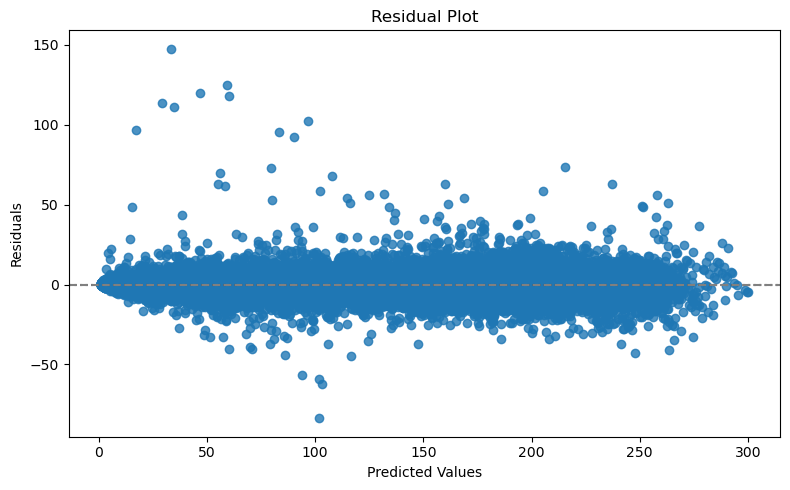

       id    Calories
0  750000   27.222017
1  750001  107.947952
2  750002   87.182053
3  750003  125.709190
4  750004   75.934334

count    250000.000000
mean         88.172859
std          62.275372
min           1.017824
25%          34.050141
50%          76.401817
75%         135.375736
max         299.757019
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05849 private, 0.05701 public (autogluon_prediction_11.csv) (tied for 14th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=54000, # 15 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_11.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [ ]:
predictor.leaderboard().head()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059075,root_mean_squared_error,7214.105045,30590.482822,0.015257,10.400178,3,True,64
1,WeightedEnsemble_L2,-0.059187,root_mean_squared_error,1472.380559,3711.962613,0.013062,8.115282,2,True,48
2,ExtraTreesMSE_BAG_L2,-0.059404,root_mean_squared_error,6798.435167,25700.223948,30.450780,526.690415,2,True,53
3,CatBoost_r9_BAG_L2,-0.059462,root_mean_squared_error,6770.174446,25586.323037,2.190059,412.789504,2,True,62
4,LightGBMLarge_BAG_L2,-0.059492,root_mean_squared_error,6777.622296,25247.191057,9.637909,73.657524,2,True,57


In [ ]:
info['model_info']['WeightedEnsemble_L3']['features']

['ExtraTreesMSE_BAG_L2',
 'CatBoost_r167_BAG_L1',
 'CatBoost_r69_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBMLarge_BAG_L2',
 'LightGBMXT_BAG_L2',
 'NeuralNetFastAI_r156_BAG_L1',
 'CatBoost_r9_BAG_L2',
 'LightGBMLarge_BAG_L1',
 'XGBoost_r33_BAG_L1',
 'XGBoost_r194_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'CatBoost_r177_BAG_L2',
 'RandomForest_r39_BAG_L1']

In [ ]:
info['model_info']['WeightedEnsemble_L3']

{'name': 'WeightedEnsemble_L3',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'stopping_metric': 'root_mean_squared_error',
 'fit_time': 10.40017819404602,
 'num_classes': None,
 'quantile_levels': None,
 'predict_time': 0.01525735855102539,
 'val_score': np.float64(-0.059075210416038915),
 'hyperparameters': {'use_orig_features': False,
  'valid_stacker': True,
  'max_base_models': 0,
  'max_base_models_per_type': 'auto',
  'save_bag_folds': True,
  'stratify': 'auto',
  'bin': 'auto',
  'n_bins': None},
 'hyperparameters_user': {'save_bag_folds': True},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': ['save_bag_folds'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': None,
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
 

In [ ]:
predictor.feature_importance(train_data)

,importance,stddev,p_value,n,p99_high,p99_low
Duration,0.806995,0.010962,4.084816e-09,5,0.829567,0.784424
Heart_Rate,0.461166,0.013544,8.917708e-08,5,0.489054,0.433279
Age,0.113267,0.002252,1.872867e-08,5,0.117903,0.108631
Sex,0.059944,0.002045,1.622515e-07,5,0.064154,0.055733
Body_Temp,0.035696,0.001747,6.869874e-07,5,0.039294,0.032098
Weight,0.016841,0.000698,3.534277e-07,5,0.018278,0.015404
Height,0.004005,0.000377,9.331977e-06,5,0.004781,0.003228
